<a target="_blank" href="https://colab.research.google.com/github/holmrenser/deep_learning/blob/main/markov_prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Markov prediction
In this notebook we will implement (arguably) the most simple form of sequence generation: each subsequent token (character) is generated by sampling from the conditional probability distribution $P(X_t \mid X_{t-1}) \sim Multinomial_{X_{t-1}}(N_{tokens})$, i.e. every character (token) has an associated probility table for what the next character (token) will be. 'Training' proceeds through simple counting of observed character pairs.

We start with a very minimal implementation and then proceed to introduce some boilerplate for dataloading, model forwarding, and training. Whereas this is not strictly necesarry for this model, it makes comparisons with later more complex models more straightforward. More importantly, our advanced implementation will be generalized to higher order markov chains, for example a model of order two: $P(X_t \mid X_{t-1}, X_{t-2}) \sim Multinomial_{X_{t-1}, X_{t-2}}(N_{tokens})$.This will allow us to explore the limits of conditional probability lookup tables (e.g. in terms of number of parameters).

In [241]:
from dataclasses import dataclass
import math
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from dataclasses import dataclass, field

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

# Data

We use the tiny shakespeare dataset to train a character level markov model to predict text that looks very little like shakespeare. All data is in one text file, which we download below.

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-15 16:13:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1,1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1,06M  --.-KB/s    in 0,1s    

2024-02-15 16:13:29 (8,29 MB/s) - ‘input.txt’ saved [1115394/1115394]



# Minimal implementation
Below is a very minimal implementation of generating a text sample using 'markov prediction': every next token is sampled according to a probability based only on the previous token. 'Training' consists of counting observed character pairs. We don't calculate a loss and model evaluation is based on vibes.

  0%|          | 0/10000 [00:00<?, ?it/s]

Sample:

TLHJOr:
Angat-MYoulatotinv'!
Fzre saxirere t thesMENERwe
BYorimVAf f vwe imQg
FOFZor riritrd&Londhedersurirous.
An:
MENIE$u
Fis couADYALof tSllAgarebourtjCic;Fo m-cunDJ&vesb-xgDJW:
MrinLZinikit bs st as,jfo
WZ&&.
IVBXP3flllleve:
FhKpr tse g rse ouhay,
AKat



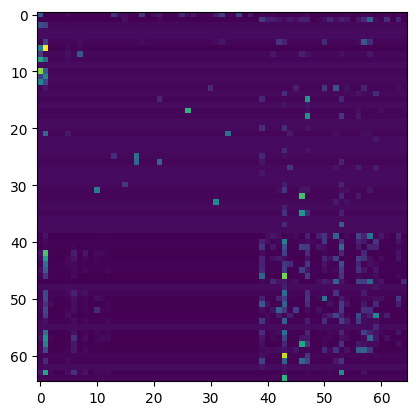

In [19]:
with open('input.txt') as fh:
    data = fh.read()

# create a sorted list of unique characters
chars = sorted(list(set(data)))
# count how many 'tokens'
vocab_size = len(chars)
# map characters to integers
encode = { ch:i for i,ch in enumerate(chars) }
# map integers to characters
decode = { i:ch for i,ch in enumerate(chars) }

# initialize counts with ones for automatic laplace/additive smoothing: https://en.wikipedia.org/wiki/Additive_smoothing
counts = torch.ones(vocab_size, vocab_size)

# 'train' (i.e. count) for n steps (i.e. character pairs)
n_train_chars = 10000
for i in trange(n_train_chars):
    token_i = encode[data[i]]
    token_j = encode[data[i+1]]
    counts[token_i][token_j] += 1

# divide by row sums to get transition probabilities
probs = counts / counts.sum(dim=1, keepdim=True)

# start our sample with token 0 (i.e. the newline character \n)
sample = [0]
sample_n_tokens = 256

# for n steps, sample a token from the distribution belonging the last token in the current sample and add it to the sample
for _ in range(sample_n_tokens):
    next_token = torch.multinomial(probs[sample[-1]], num_samples=1)
    sample.append(next_token.item())

# decode sample tokens into characters
decoded_sample = ''.join(decode[token] for token in sample)
print(f'Sample:\n{decoded_sample}\n')

# plot observed transition probabilities
plt.imshow(probs)

# Advanced implementation

## Data

In [596]:
@dataclass
class CharacterTokenizer:
    decode_dict: dict[int, str] = field(default_factory=dict)
    encode_dict: dict[str, int] = field(default_factory=dict)

    def get_vocab(self):
        """Character to int mapping"""
        return self.encode_dict

    def train(self, input_str: str) -> None:
        """Determine what character will be mapped to which int using lexicograpical order"""
        chars = sorted(set(input_str))
        self.decode_dict: dict[int, str] = dict(enumerate(chars))
        self.encode_dict: dict[str, int] = {v:k for k,v in self.decode_dict.items()}

    def encode(self, input: str) -> list[int]:
        """Turn a string into a list of ints using a pretrained lookup table"""
        return [self.encode_dict[char] for char in input]

    def decode(self, tokens: list[int]) -> str:
        """Turn a list of ints into a string using a reverse lookup table"""
        return ''.join(self.decode_dict[token] for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, block_size: int=256, order: int=1):
        assert order > 0, 'Order must be > 1'
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.block_size = block_size
        self.order = order

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        block_size = self.block_size
        order = self.order
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {block_size=}, {order=})'

    @classmethod
    def from_textfile(cls, filename: str, block_size: int=256, order: int=1) -> 'CharacterDataset':
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, block_size=block_size, order=order)

    def train_test_split(self, train_percentage: float=0.8) -> Tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.tokenizer, self.block_size, self.order)

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.tokenizer, self.block_size, self.order)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.block_size - self.order

    def __getitem__(self, idx: int) -> torch.tensor:
        # grab a chunk of block_size characters from the data
        chunk = self.data[idx:idx + self.block_size + self.order]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # determine indices based on order
        x_indices = (
            torch.arange(self.block_size).unsqueeze(1) # determine starting indices and add empty dim
            + torch.arange(self.order).repeat(self.block_size, 1) # add range(0, order) to get ranges of len(order) at every starting index
        )
        # return relevant tokens based on indices
        x = tokens[x_indices]
        y = tokens[self.order:]
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892058, 222822)

## Model

In [595]:
class MarkovPredictor(nn.Module):
    """Very simple model for next character prediction by counting observed character pairs"""
    def __init__(self, vocab_size, order=1):
        assert order > 0, 'Order must be > 1'
        super().__init__()
        self.order = order
        # counting character pairs in a vocab_size ** (order + 1) table
        self.counts = torch.ones([vocab_size] * (order + 1))

    def __repr__(self) -> str:
        order = self.order
        return f'MarkovPredictor({order=})'

    @property
    def probs(self) -> torch.tensor:
        """Normalize counts to probabilities by dividing over row sums"""
        return self.counts / self.counts.sum(dim=-1, keepdim=True)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None):
        # (B, L, order) -> (B, L, vocab_size)
        probs = self.probs[*idx.permute(2,1,0)].permute(1,0,2)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(probs.view(-1, probs.size(-1)), targets.view(-1), ignore_index=-1)
        return probs,loss

    def generate(self, n_samples: int=1, sample_length: int=256, deterministic: bool=False):
        """Generate samples"""
        idx = torch.zeros((n_samples, self.order), dtype=torch.long)
        for _ in trange(sample_length):
            x_indices = torch.arange(idx.shape[1] - self.order, idx.shape[1])
            x = torch.vstack([idx[i, x_indices][None][None] for i in range(n_samples)])
            probs,_ = model(x)
            new_idx = torch.multinomial(probs.squeeze(1), num_samples=1)
            idx = torch.hstack([idx, new_idx])

        samples = []
        for sample in idx:
            samples.append(dataset.tokenizer.decode(sample.tolist()))
        return samples

dataset = CharacterDataset.from_textfile('./input.txt', block_size=12, order=3)
model = MarkovPredictor(vocab_size = dataset.vocab_size, order = dataset.order)

print(dataset)
print(model)

for sample in model.generate():
    print(sample)

CharacterDataset(n_chars=1115394, vocab_size=65, block_size=12, order=3)
MarkovPredictor(order=3)


  0%|          | 0/256 [00:00<?, ?it/s]




dBa,DWgHc$Gwa?aABatJRad$PwXrkz;SSRcsq;YW&W3
ExIjmDQURYvaf'Nk.NWzPi3YXD'
MSygILM!XMKbhVs x-MKYv!GxfYQJCTXEfrG? D&UtV??hGwfHqad
loIn&MBPa
z lvI!N'nXWQ,3Qd,JDRUpC. S,Ivw:xxbQOSv?SL?dAN$$afShHCKlyURB3ceDUk$rsI:iu;Z3xiAGHwFYTH:kkeE,
hNsiJS,uUzI.ZNQV!V,,
SXLJLKI


## Training
Note that whereas we can call this 'training', all the code below does is count character pairs and update the pair count table of the model.

In [590]:
dataset = CharacterDataset.from_textfile('./input.txt', block_size=256, order=3)
train_dataset, test_dataset = dataset.train_test_split()

model = MarkovPredictor(dataset.vocab_size, dataset.order)

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=False, num_samples=100000),
    batch_size=50
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=False, num_samples=1000),
    batch_size=50
)
test_dataloader = iter(test_dataloader)

train_loss = []
test_loss = []

for i, train_batch in enumerate(tqdm(train_dataloader)):
    for x,y in zip(*train_batch):
        model.counts[*x.T,y] += 1
    if i % 100 == 0:
        test_batch = next(test_dataloader)
        test_loss.append(model(*test_batch)[1])
        train_loss.append(model(*train_batch)[1])

for sample in model.generate():
    print(sample)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]




ANTIO:
Lest Senator, what than easlNGZWnrjhPLn:AD UgV,!p!zZMdVamman's trese a man sadder may'd: when, my shrich hen yet is fault?

MONTES:
King fore a sitsewishoul into.

Secons may you good affender lordship
To seech excygI-zq:SmJGy-t,bqr$qOpQBOHHZ?d!Ub w


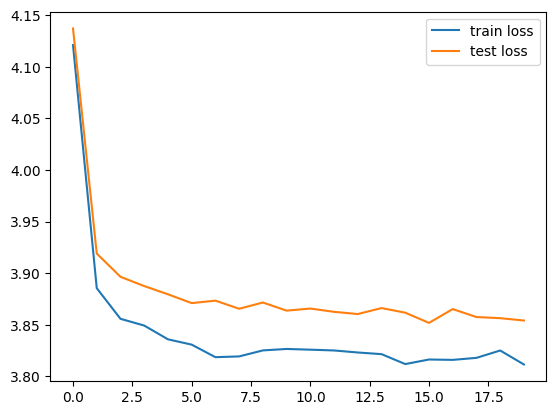

In [591]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()

## Evaluation
The model has learned some structure, e.g. there are probably a bit more newlines and a colon is always followed by a newline. 

In [371]:
for sample in model.generate():
    print(sample)

  0%|          | 0/256 [00:00<?, ?it/s]



iRoys dns h medpAWIdonaoe aieN
rpo
sAu ls ;
oto ohmtmtowsuo
iieaetaaws' li pt
niHu wootsdUo,heHth sdtWT
sifu,rw wde.e sdTL
lao,k,a,Mn I
oyhA ukcw
 e Rhfeya uhchw dylirr
Iteaomter, eouudenoha hi  ctftssra a t ttnnc :W
eeoehjde  
b uefo  oEbm: lgade nn:Teci
